<a href="https://colab.research.google.com/github/derrickrajkumar10-tech/FUTURE_ML_01/blob/main/notebooks/sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing required packages
!pip install prophet pandas matplotlib seaborn plotly scikit-learn openpyxl

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 139.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.3 MB/s eta 0:00:00
✅ All libraries installed successfully!


In [5]:
from google.colab import files
uploaded = files.upload()

Saving Sample - Superstore.csv to Sample - Superstore.csv


In [11]:

df = pd.read_csv('Sample - Superstore.csv', encoding='latin1')

print(df.head())
print(df.info())
print(df.columns)

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   Sout

Missing values:
 Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

Date range: 1/1/2017 to 9/9/2017

Sales summary:
 count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64


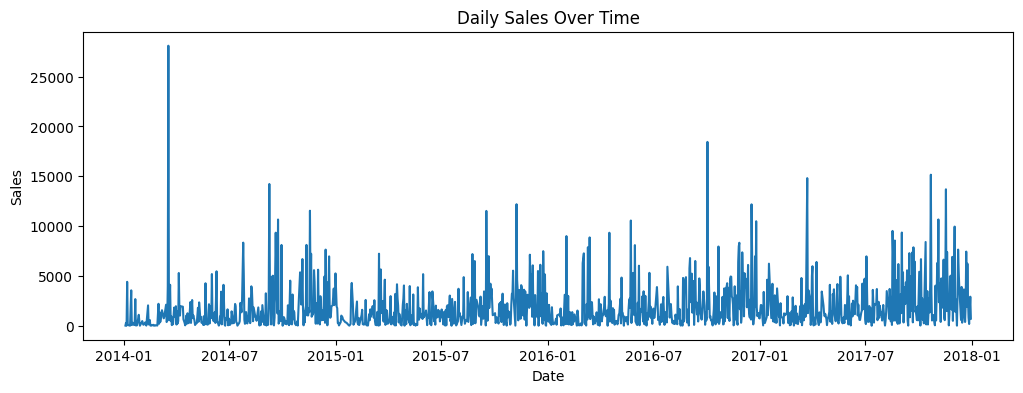

In [12]:
# EXPLORATORY DATA ANALYSIS
print("Missing values:\n", df.isnull().sum())

# Looking at date column (usually 'Order Date' or 'Date')
print("\nDate range:", df['Order Date'].min(), "to", df['Order Date'].max())

# Checking sales column
print("\nSales summary:\n", df['Sales'].describe())

# Basic visualization
df['Order Date'] = pd.to_datetime(df['Order Date'])
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

plt.figure(figsize=(12,4))
plt.plot(daily_sales['Order Date'], daily_sales['Sales'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Training data: 989 days
Test data: 248 days
Training model...
✅ Model trained!


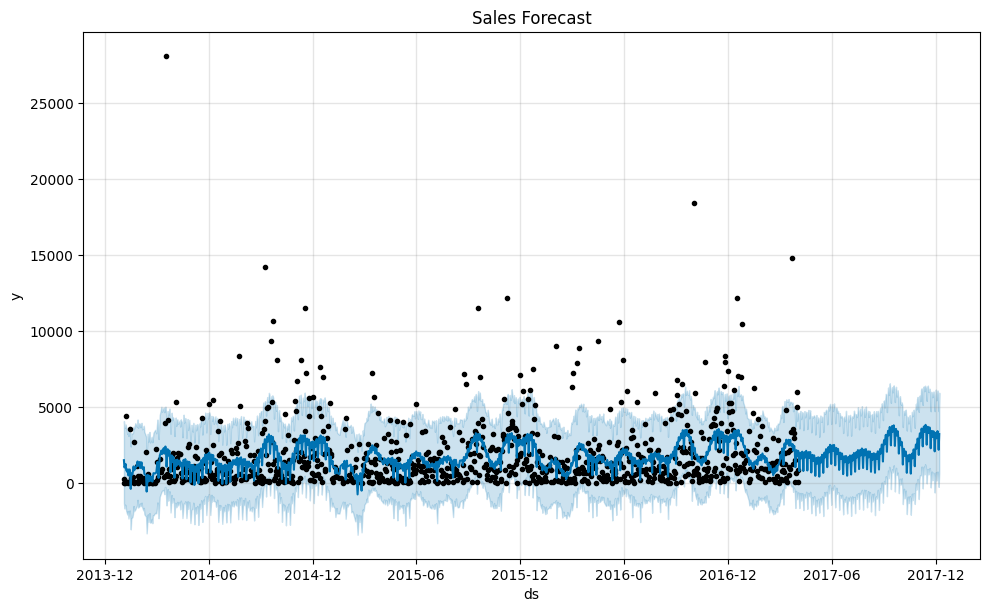

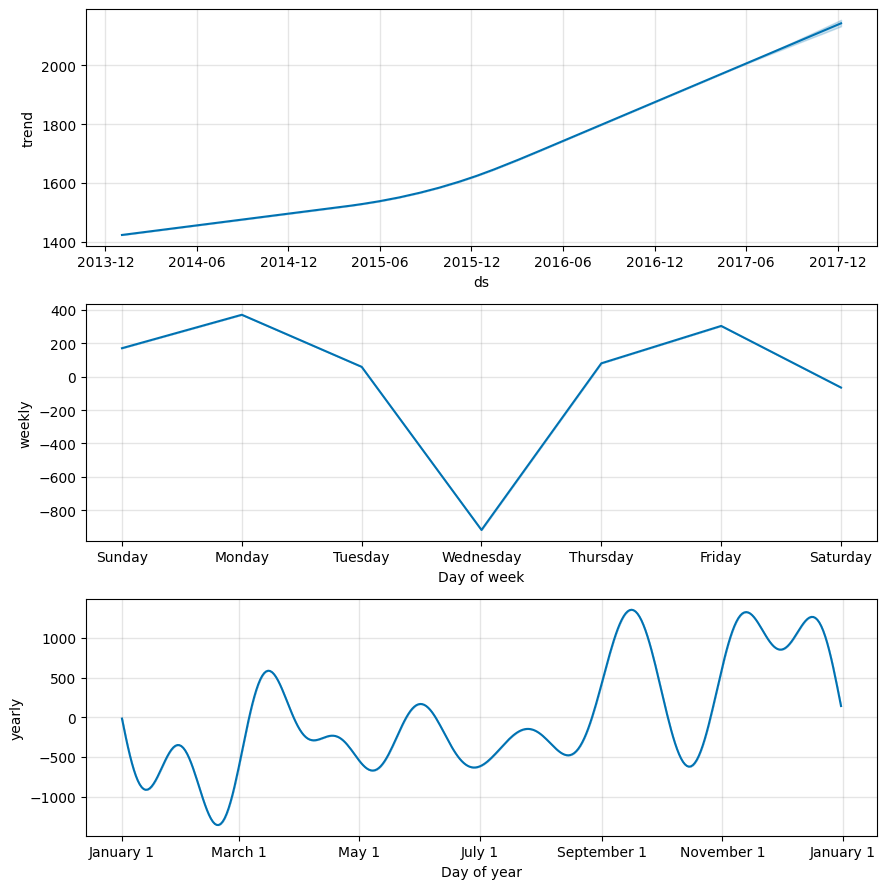

In [13]:
# Preparing data for Prophet (needs 'ds' and 'y' columns)
df_prophet = daily_sales.copy()
df_prophet.columns = ['ds', 'y']  # Prophet requires these exact names

# Split data: 80% train, 20% test
split_point = int(len(df_prophet) * 0.8)
train = df_prophet[:split_point]
test = df_prophet[split_point:]

print(f"Training data: {len(train)} days")
print(f"Test data: {len(test)} days")

# Creating  and train model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

print("Training model...")
model.fit(train)
print("Model trained!")

# Making predictions
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('Sales Forecast')
plt.show()

# Components (trend, seasonality)
fig2 = model.plot_components(forecast)
plt.show()

📊 Model Performance:
MAE: $1685.73
RMSE: $2368.42
MAPE: 564.99%


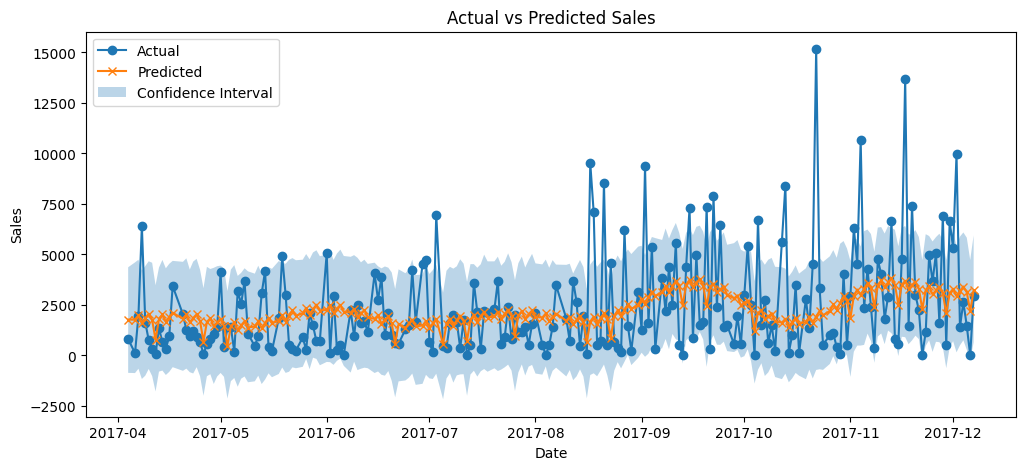

In [14]:
# Compare predictions vs actual on test set
test_forecast = forecast.iloc[split_point:][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
test_forecast = test_forecast.merge(test, on='ds')

# Calculate accuracy
mae = mean_absolute_error(test_forecast['y'], test_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(test_forecast['y'], test_forecast['yhat']))
mape = np.mean(np.abs((test_forecast['y'] - test_forecast['yhat']) / test_forecast['y'])) * 100

print(f"📊 Model Performance:")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(test_forecast['ds'], test_forecast['y'], label='Actual', marker='o')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Predicted', marker='x')
plt.fill_between(test_forecast['ds'],
                 test_forecast['yhat_lower'],
                 test_forecast['yhat_upper'],
                 alpha=0.3, label='Confidence Interval')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()